In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time

# Definir el generador y el discriminador
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            #nn.Linear(input_dim, 128),
            #nn.ReLU(),
            #nn.Linear(128, 256),
            #nn.ReLU(),
            #nn.Linear(256, output_dim),
            #nn.Tanh()
                    
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            
            nn.Linear(512, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            
            nn.Linear(768, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            #nn.Linear(1024, 768),
            #nn.BatchNorm1d(768),
            #nn.ReLU(),
            
            #nn.Linear(768, 512),
            #nn.BatchNorm1d(512),
            #nn.ReLU(),
            
            nn.Linear(1024, output_dim),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            #nn.Linear(input_dim, 256),
            #nn.LeakyReLU(0.2),
            #nn.Linear(256, 256),
            #nn.LeakyReLU(0.2),
            #nn.Linear(256, 128),
            #nn.LeakyReLU(0.2),
            #nn.Linear(128, 1),
            #nn.Sigmoid()
            
            nn.Linear(input_dim, 256),
            #nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
        
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            #nn.Linear(128, 64),
            #nn.BatchNorm1d(64),
            #nn.ReLU(),
            #nn.Dropout(0.3),
    
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.net(x)
        
# Leer datos
expression_data = pd.read_csv('expr.csv')
methylation_data = pd.read_csv('methyl.csv')
assign_data = pd.read_csv('assign.csv')

expression_data = expression_data.iloc[:, 1:]
methylation_data = methylation_data.iloc[:, 1:]
assign_data = assign_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expression_data = expression_data.apply(pd.to_numeric, errors='coerce')
methylation_data = methylation_data.apply(pd.to_numeric, errors='coerce')
assign_data = assign_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expression_data.fillna(0, inplace=True)
methylation_data.fillna(0, inplace=True)
assign_data.fillna(0, inplace=True)

expression_data = expression_data.values
methylation_data = methylation_data.values
assign_data=assign_data.values
# Asegurar que tienes el mismo número de muestras en ambos conjuntos de datos


assert expression_data.shape[0] == methylation_data.shape[0], "Los datos de expresión y metilación deben tener el mismo número de muestras."
assert assign_data.shape[0] == methylation_data.shape[0], "Los datos de asignación y metilación deben tener el mismo número de muestras."

# Concatenar los datos
#combined_data =torch.FloatTensor(np.hstack((expression_data, methylation_data,assign_data)))
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"
expression_data = torch.FloatTensor(expression_data).to(device)
methylation_data = torch.FloatTensor(methylation_data).to(device)
assign_data = torch.FloatTensor(assign_data).to(device)
combined_data = torch.cat((expression_data,methylation_data,assign_data), 1).to(device)

True


In [14]:





# Modelos y optimizadores
gen = Generator(100, methylation_data.shape[1]+assign_data.shape[1]).to(device)
disc = Discriminator(expression_data.shape[1] + methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen_optimizer = optim.Adam(gen.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(disc.parameters(), lr=0.0002)
criterion = nn.BCELoss()

# Entrenamiento
n_samples = combined_data.size(0)
batch_size = 64
n_epochs = 10000
start_time = time.time()
for epoch in range(n_epochs):
    for idx in range(0, n_samples, batch_size):
        real_data = combined_data[idx:idx+batch_size].to(device)
        current_batch_size = real_data.size(0)
        real_labels = torch.ones(current_batch_size, 1).to(device)

        noise = torch.randn(current_batch_size, 100).to(device)
        #noise = expression_data[idx:idx+batch_size]
        
        fake_methyl = gen(noise).to(device)
        #fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl), 1)

        fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl ), 1).to(device)

        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        
        # Entrenar discriminador
        disc_optimizer.zero_grad()

        real_preds = disc(real_data).to(device)
        real_loss = criterion(real_preds, real_labels)
        
        fake_preds = disc(fake_data).to(device)
        fake_loss = criterion(fake_preds, fake_labels)

        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        disc_optimizer.step()

        # Entrenar generador
        gen_optimizer.zero_grad()

        noise = torch.randn(current_batch_size, 100).to(device)
        fake_methyl = gen(noise).to(device)
        fake_data = torch.cat((expression_data[idx:idx+batch_size],fake_methyl ), 1).to(device)
        fake_preds = disc(fake_data).to(device)

        gen_loss = criterion(fake_preds, real_labels)
        gen_loss.backward()
        gen_optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Disc Loss: {disc_loss.item()} | Gen Loss: {gen_loss.item()}")
        end_time = time.time()

        # Calcular la diferencia de tiempo
        elapsed_time = end_time - start_time

        print(f"El código tardó {elapsed_time:.5f} segundos en ejecutarse.")
        start_time = time.time()

torch.save(gen.state_dict(), 'generator_model.pth')




Epoch 100/10000 | Disc Loss: 0.000807556149084121 | Gen Loss: 10.889925003051758
El código tardó 112.72470 segundos en ejecutarse.
Epoch 200/10000 | Disc Loss: 0.002753788372501731 | Gen Loss: 13.62681770324707
El código tardó 121.73309 segundos en ejecutarse.
Epoch 300/10000 | Disc Loss: 0.001795490738004446 | Gen Loss: 16.125633239746094
El código tardó 105.47391 segundos en ejecutarse.
Epoch 400/10000 | Disc Loss: 3.386068783584051e-05 | Gen Loss: 17.280067443847656
El código tardó 104.03243 segundos en ejecutarse.
Epoch 500/10000 | Disc Loss: 4.6130116970743984e-05 | Gen Loss: 13.773537635803223
El código tardó 106.32831 segundos en ejecutarse.
Epoch 600/10000 | Disc Loss: 1.7357740944135003e-05 | Gen Loss: 15.520808219909668
El código tardó 107.96036 segundos en ejecutarse.
Epoch 700/10000 | Disc Loss: 0.003645859891548753 | Gen Loss: 18.902584075927734
El código tardó 94.09130 segundos en ejecutarse.
Epoch 800/10000 | Disc Loss: 0.0001916400797199458 | Gen Loss: 28.19015121459961

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Generar datos de expresión sintética
gen2 = Generator(100, methylation_data.shape[1]+assign_data.shape[1]).to(device)
gen2.load_state_dict(torch.load('generator_model.pth'))
gen2.eval()
expressions_list = []
for i in range(10000):
    noise = torch.randn(1, 100).to(device)
    synthetic_expression = gen2(noise).to(device)
    #print(synthetic_expression)
    expressions_list.append(synthetic_expression.detach().cpu().numpy().squeeze())

X = pd.DataFrame(expressions_list)
#X = X.apply(pd.to_numeric, errors='coerce')
y = X.iloc[:, -1].values.astype(int)  # Suponiendo que la asignación está en la primera columna

X = X.iloc[:, :-1]
# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

ValueError: The number of classes has to be greater than one; got 1 class

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     23934
           2       1.00      1.00      1.00      6066

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



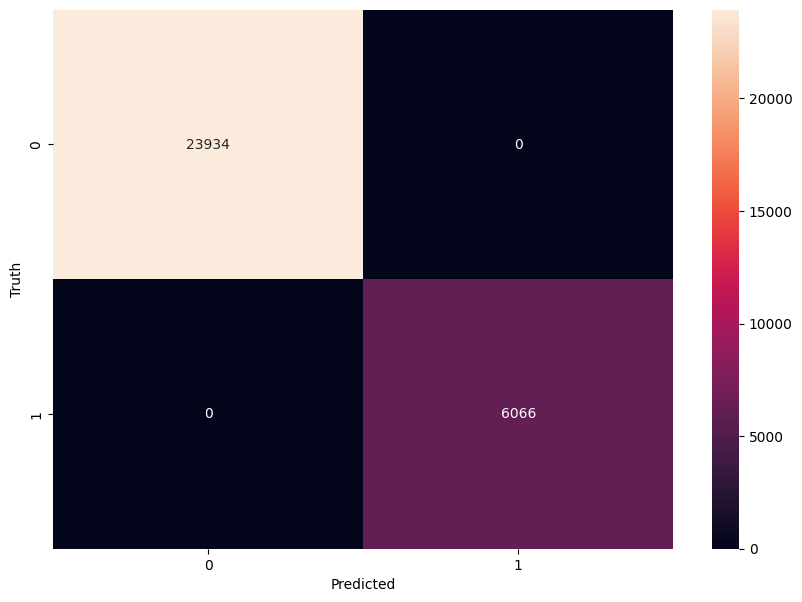

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprMID.csv')
meth_data = pd.read_csv('methylMID.csv')
assig_data = pd.read_csv('assignMID.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = pd.concat([expr_data, meth_data], axis=1)
y = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


              precision    recall  f1-score   support

           1       1.00      1.00      1.00     23934
           2       1.00      1.00      1.00      6066

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



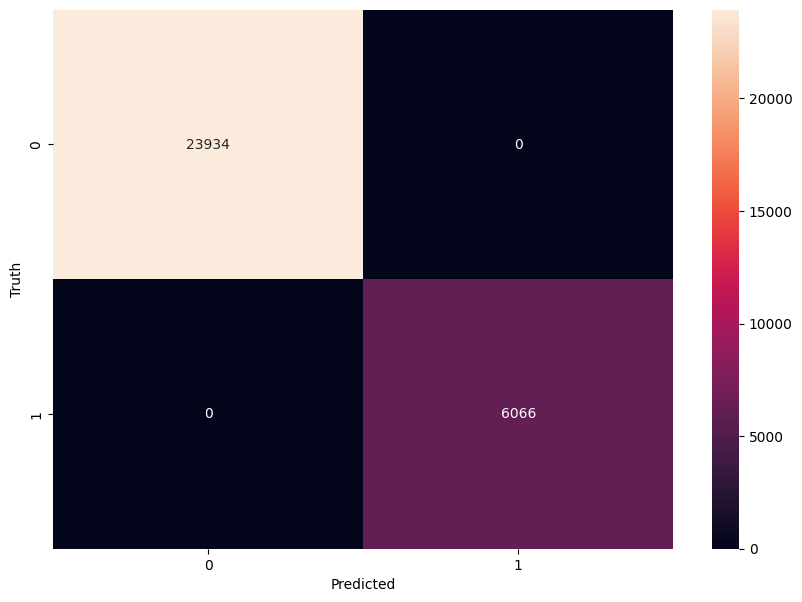

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Cargamos los datos
expr_data = pd.read_csv('exprMID.csv')
meth_data = pd.read_csv('methylMID.csv')
assig_data = pd.read_csv('assignMID.csv')
expr_data = expr_data.iloc[:, 1:]
meth_data = meth_data.iloc[:, 1:]
assig_data = assig_data.iloc[:, 2:]

# Convertir todas las columnas a tipo float
expr_data = expr_data.apply(pd.to_numeric, errors='coerce')
meth_data = meth_data.apply(pd.to_numeric, errors='coerce')
assig_data = assig_data.apply(pd.to_numeric, errors='coerce')
# Lidiar con valores NaN (si los hay). Pone 0(CAMBIAR)
expr_data.fillna(0, inplace=True)
meth_data.fillna(0, inplace=True)
assig_data.fillna(0, inplace=True)
# Aseguramos que las dimensiones coincidan
assert expr_data.shape[0] == meth_data.shape[0] == assig_data.shape[0], "Las dimensiones de los archivos no coinciden"

# Combinamos los datos de expresión génica y metilación
X = meth_data
y = assig_data.iloc[:, 0].values  # Suponiendo que la asignación está en la primera columna

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamos el modelo SVC
clf = SVC()
clf.fit(X_train, y_train)

# Predicciones
y_pred = clf.predict(X_test)

# Métricas de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
